<a href="https://colab.research.google.com/github/amirkasaei/Image-Segemntation-CamVid/blob/main/SegNet_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [1]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Softmax, BatchNormalization, Dropout, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Activation, add, ZeroPadding2D, UpSampling2D, concatenate, Reshape
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from tensorflow.keras import Model
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import seaborn as sns
from copy import deepcopy


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.model_selection import KFold


import os
import sys
import time
import cv2 as cv

**GPU**

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **Preprocess**

### **Google Drive mount**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = "/content/drive/MyDrive/dataset/CamVid/"

### **Data Visualization**

In [5]:
img = np.array(load_img(path + 'camvid/images/' + '0001TP_006690.png'))
mask = np.array(load_img(path + 'LabeledApproved/' + '0001TP_006690_L.png'))

In [6]:
original_input_shape = np.array(img).shape
original_input_shape

(720, 960, 3)

Text(0.5, 1.0, 'Mask')

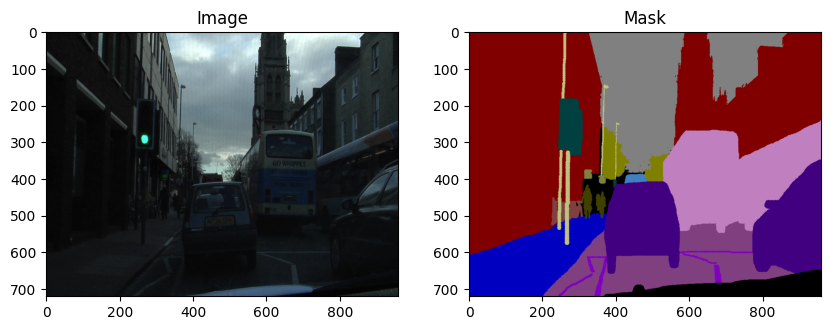

In [7]:
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Mask')

In [8]:
scale = 0.16666

In [9]:
resized_img = cv.resize(img, (0,0), fx=scale, fy=scale)/255.0
resized_mask = cv.resize(mask, (0,0), fx=scale, fy=scale)
resized_img.shape

(120, 160, 3)

Text(0.5, 1.0, 'Mask')

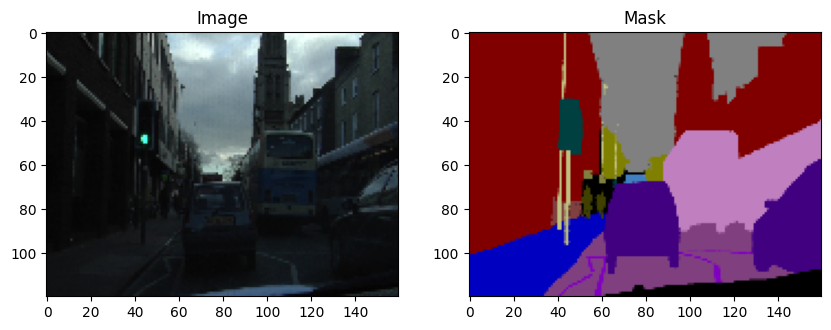

In [10]:
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(resized_img)
arr[0].set_title('Image')
arr[1].imshow(resized_mask)
arr[1].set_title('Mask')

### **Feature Adjustment**

In [11]:
classes = pd.read_csv(path + 'class_dict.csv', index_col=0)
classes

,r,g,b
name,,,
Animal,64,128,64
Archway,192,0,128
Bicyclist,0,128,192
Bridge,0,128,64
Building,128,0,0
Car,64,0,128
CartLuggagePram,64,0,192
Child,192,128,64
Column_Pole,192,192,128


In [12]:
n_classes = len(classes)
n_classes

32

In [13]:
classes.index

Index(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone', 'TrafficLight',
       'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void',
       'Wall'],
      dtype='object', name='name')

In [14]:
cls2rgb = {cl:list(classes.loc[cl, :]) for cl in classes.index}

In [15]:
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}

In [16]:
def adjust_mask(mask, flat=False):
    semantic_map = []
    for colour in list(cls2rgb.values()):
        equality = np.equal(mask, colour)# image size of True or False
        class_map = np.all(equality, axis = -1)# image size of values If all True, then True, else False
        semantic_map.append(class_map)# List of 256x256 arrays, map of True for a given found color at the pixel, and False otherwise.
    semantic_map = np.stack(semantic_map, axis=-1)# 256x256x32 True only at the found color, and all False otherwise.

    # if flat:
    #   semantic_map = np.reshape(semantic_map, (-1, resized_img.shape[0]*resized_img.shape[1]))

    return np.float32(semantic_map)# convert to numbers

In [17]:
# Map the idx back to rgb
def map_class_to_rgb(p):
  return idx2rgb[p[0]]

In [18]:
def unadjust_mask(new_mask):
  return np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(new_mask, axis=-1), -1))

In [19]:
#convert orgignal image
new_mask = adjust_mask(resized_mask)
new_mask.shape

(120, 160, 32)

In [20]:
rgb_mask = unadjust_mask(new_mask)
rgb_mask.shape

(120, 160, 3)

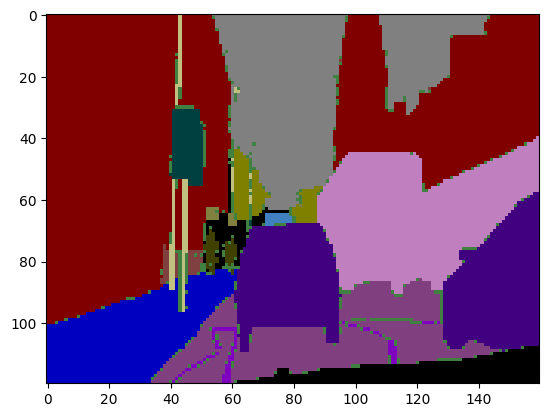

In [21]:
plt.imshow(rgb_mask)

### **Load images**

In [22]:
flat = False

In [23]:
images, masks = [], []
for filename in os.listdir(path + 'camvid/images/'):

    img = np.array(load_img(path + 'camvid/images/' + filename))

    mask = np.array(load_img(path + 'LabeledApproved/' + filename[:-4] + '_L.png'))

    if img is not None and mask is not None:
      img = cv.resize(mask, (0,0), fx=scale, fy=scale)/255.0

      mask = cv.resize(mask, (0,0), fx=scale, fy=scale)
      mask = adjust_mask(mask)

      images.append(img)
      masks.append(mask)

In [24]:
# images = np.array(images)
# masks = np.array(masks)

### **Feature Selection**

In [25]:
# x = images
# y = masks
# if(flat):
#   y = np.reshape(len(y), len(y[1])*len(y[1]))
#   y = np.expand_dims(masks, axis=-1)

In [26]:
input_shape = images[0].shape
input_shape

(120, 160, 3)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(np.array(images), np.array(masks), test_size=0.1)

In [28]:
y_test.shape

(71, 120, 160, 32)

In [29]:
x_train.shape, y_train.shape

((630, 120, 160, 3), (630, 120, 160, 32))

# **Model**

## **Helper Function**

In [30]:
def plot_confusionmatrix(y_pred,y_true, classes):
  print('Confusion matrix')
  cf = confusion_matrix(y_pred,y_true)
  sns.heatmap(cf,annot=True,yticklabels=classes, xticklabels=classes, cmap='Blues', fmt='g')
  plt.tight_layout()
  plt.show()

In [31]:
def showPlots(history):
    plt.plot(history['accuracy'], label='training accuracy', marker='.', color='green')
    plt.plot(history['val_accuracy'], label='test accuracy', marker='.', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history['loss'], label='training loss', marker='.', color='green')
    plt.plot(history['val_loss'], label='test loss', marker='.', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## **Implementation**

In [32]:
kernel_size = 7
filter_size = 64
pool_size = 2
height = input_shape[0]
width = input_shape[1]
data_shape = input_shape[0]*input_shape[1]
batch_normalization = False

In [33]:
inputs = Input(shape=input_shape)
# ------------------------------------ down 1----------------------------------------
conv1 = Conv2D(filter_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
if(batch_normalization):
  conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
# ------------------------------------ down 2 ----------------------------------------
conv2 = Conv2D(2*filter_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
if(batch_normalization):
  conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
# ------------------------------------ down 3 ----------------------------------------
conv3 = Conv2D(4*filter_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
if(batch_normalization):
  conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
# ------------------------------------ down 4 ----------------------------------------
conv4 = Conv2D(8*filter_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
if(batch_normalization):
  conv4 = BatchNormalization()(conv4)


# ------------------------------------ up 1 ----------------------------------------
up5 = Conv2D(8*filter_size, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4)
conv5 = Conv2D(8*filter_size, kernel_size, activation = None , padding = 'same', kernel_initializer = 'he_normal')(up5)
if(batch_normalization):
  conv5 = BatchNormalization()(conv5)
# ------------------------------------ up 2 ----------------------------------------
up6 = Conv2D(4*filter_size, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
conv6 = Conv2D(4*filter_size, kernel_size, activation = None, padding = 'same', kernel_initializer = 'he_normal')(up6)
if(batch_normalization):
  conv6 = BatchNormalization()(conv6)
# ------------------------------------ up 3 ----------------------------------------
up7 = Conv2D(2*filter_size, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
conv7 = Conv2D(2*filter_size, kernel_size, activation = None, padding = 'same', kernel_initializer = 'he_normal')(up7)
if(batch_normalization):
  conv7 = BatchNormalization()(conv7)
# ------------------------------------ up 4 ----------------------------------------
up8 = Conv2D(filter_size, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
conv8 = Conv2D(filter_size, kernel_size, activation = None, padding = 'same', kernel_initializer = 'he_normal')(up8)
if(batch_normalization):
  conv8 = BatchNormalization()(conv8)

convOut = Conv2D(n_classes, (1,1), padding='same')(conv8)

if flat:
  outputs = Reshape((data_shape, n_classes))(convOut)
else:
  outputs = convOut

outputs = Activation('softmax')(outputs)


### **without batch norm**

In [34]:
segnet = Model(inputs, outputs)
segnet.summary()
segnet.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 160, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 160, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 80, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 80, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 40, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 40, 256)       160588

### **with batch norm**

In [37]:
segnet_bn = Model(inputs, outputs)
segnet_bn.summary()
segnet_bn.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 160, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 160, 64)      9472      
                                                                 
 batch_normalization (BatchN  (None, 120, 160, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 80, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 80, 128)       401536    
                                                                 
 batch_normalization_1 (Batc  (None, 60, 80, 128)      512   

## **Train**

### **without batch norm**

In [35]:
model_checkpoint = ModelCheckpoint('segnet_camvid.hdf5', monitor='val_accuracy', save_best_only=True)

In [36]:
with tf.device('/GPU:0'):
  history = segnet.fit(x_train, y_train, validation_split=0.1, epochs=30, batch_size=16, callbacks=[model_checkpoint])

Epoch 1/30
36/36 [==============================] - 73s 1s/step - loss: 11.6369 - accuracy: 0.5014 - val_loss: 1.0871 - val_accuracy: 0.7151
Epoch 2/30
36/36 [==============================] - 38s 1s/step - loss: 0.9425 - accuracy: 0.7465 - val_loss: 0.7787 - val_accuracy: 0.7754
Epoch 3/30
36/36 [==============================] - 40s 1s/step - loss: 0.7142 - accuracy: 0.7866 - val_loss: 0.6479 - val_accuracy: 0.7979
Epoch 4/30
36/36 [==============================] - 40s 1s/step - loss: 0.5972 - accuracy: 0.8106 - val_loss: 0.5690 - val_accuracy: 0.8144
Epoch 5/30
36/36 [==============================] - 16s 453ms/step - loss: 0.8908 - accuracy: 0.7654 - val_loss: 0.6960 - val_accuracy: 0.7938
Epoch 6/30
36/36 [==============================] - 17s 471ms/step - loss: 0.8991 - accuracy: 0.7891 - val_loss: 2.3656 - val_accuracy: 0.5222
Epoch 7/30
36/36 [==============================] - 16s 451ms/step - loss: 0.8475 - accuracy: 0.7663 - val_loss: 0.6222 - val_accuracy: 0.8068
Epoch 8/30

### **with batch norm**

In [38]:
model_checkpoint = ModelCheckpoint('segnet_bn_camvid.hdf5', monitor='val_accuracy', save_best_only=True)

In [39]:
with tf.device('/GPU:0'):
  history_bn = segnet_bn.fit(x_train, y_train, validation_split=0.1, epochs=40, batch_size=16, callbacks=[model_checkpoint])

Epoch 1/40
36/36 [==============================] - 72s 1s/step - loss: 0.9847 - accuracy: 0.7563 - val_loss: 5.5646 - val_accuracy: 0.3997
Epoch 2/40
36/36 [==============================] - 17s 463ms/step - loss: 0.5277 - accuracy: 0.8445 - val_loss: 1.9197 - val_accuracy: 0.3761
Epoch 3/40
36/36 [==============================] - 20s 561ms/step - loss: 0.4160 - accuracy: 0.8670 - val_loss: 1.6320 - val_accuracy: 0.4656
Epoch 4/40
36/36 [==============================] - 23s 642ms/step - loss: 0.3526 - accuracy: 0.8797 - val_loss: 1.2229 - val_accuracy: 0.7273
Epoch 5/40
36/36 [==============================] - 22s 627ms/step - loss: 0.3193 - accuracy: 0.8871 - val_loss: 0.9293 - val_accuracy: 0.7928
Epoch 6/40
36/36 [==============================] - 24s 664ms/step - loss: 0.2940 - accuracy: 0.8925 - val_loss: 0.7860 - val_accuracy: 0.8248
Epoch 7/40
36/36 [==============================] - 24s 684ms/step - loss: 0.2672 - accuracy: 0.8985 - val_loss: 0.6169 - val_accuracy: 0.8433
Ep

## **Evaluation**

### **without Batch Normalization**

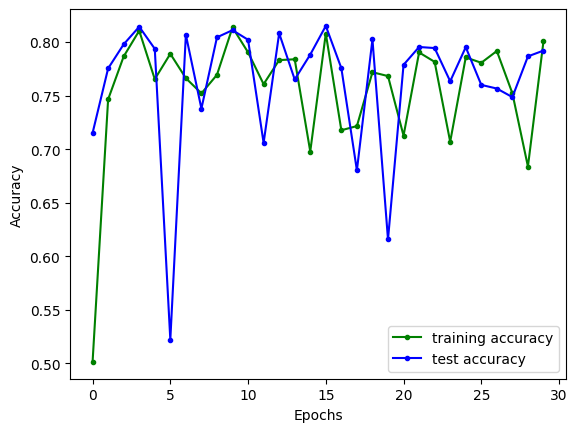

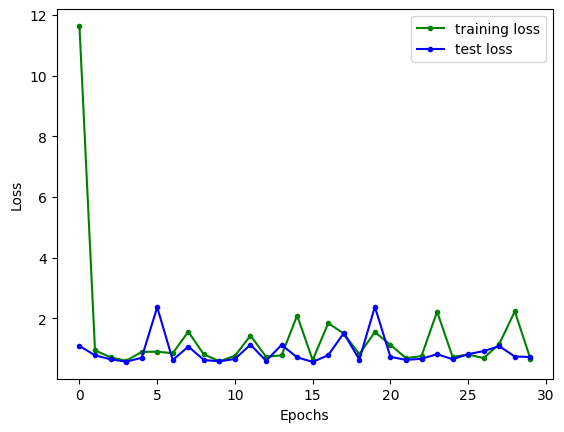

In [37]:
showPlots(history.history)

In [38]:
segnet = load_model('segnet_camvid.hdf5')

In [39]:
segnet.evaluate(x_test, y_test, batch_size=32)

3/3 [==============================] - 10s 132ms/step - loss: 0.5761 - accuracy: 0.8137


[0.5761483311653137, 0.813679575920105]

In [40]:
y_pred = segnet.predict(x_test)

3/3 [==============================] - 1s 186ms/step


In [41]:
rgb_mask_pred = unadjust_mask(y_pred[0])
rgb_mask_true = unadjust_mask(y_test[0])

Text(0.5, 1.0, 'Pred Mask')

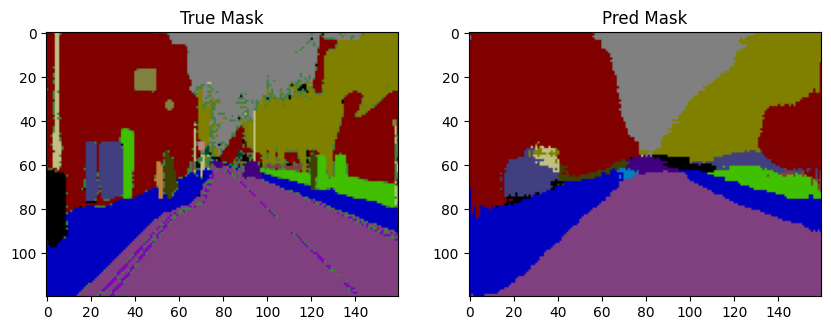

In [42]:
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(rgb_mask_true)
arr[0].set_title('True Mask')
arr[1].imshow(rgb_mask_pred)
arr[1].set_title('Pred Mask')

### **Batch Normalization**

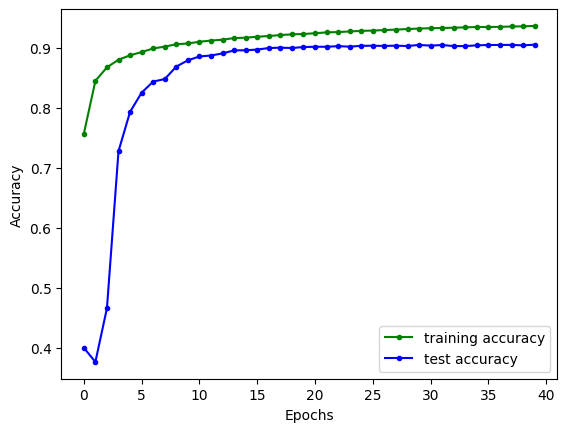

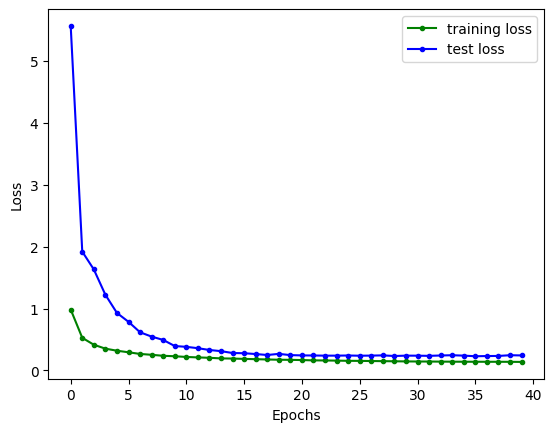

In [40]:
showPlots(history_bn.history)

In [41]:
segnet_bn = load_model('segnet_bn_camvid.hdf5')

In [42]:
segnet_bn.evaluate(x_test, y_test, batch_size=32)

3/3 [==============================] - 11s 147ms/step - loss: 0.2424 - accuracy: 0.9078


[0.2423696666955948, 0.9077868461608887]

In [43]:
y_pred = segnet_bn.predict(x_test)

3/3 [==============================] - 1s 157ms/step


In [44]:
rgb_mask_pred = unadjust_mask(y_pred[0])
rgb_mask_true = unadjust_mask(y_test[0])

Text(0.5, 1.0, 'Pred Mask')

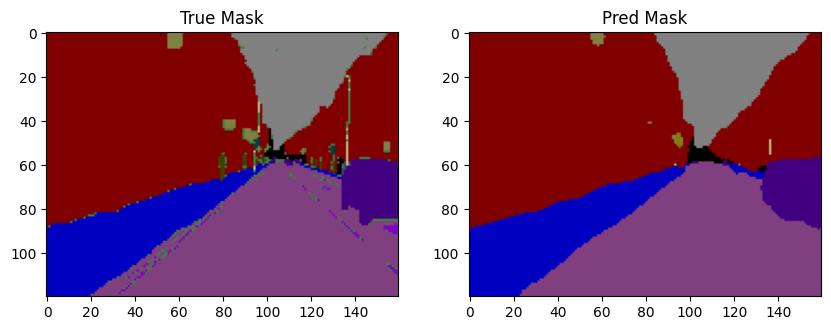

In [45]:
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(rgb_mask_true)
arr[0].set_title('True Mask')
arr[1].imshow(rgb_mask_pred)
arr[1].set_title('Pred Mask')